# Copper

Copper is a simple example, yet it still holds surprises.

Let's check the two sites that were found by AiiDA-muons

TODOs are highlighted by 🖍️, check instructions and try yourself!

In [12]:
from pymatgen.core import Structure
from ase.io import read
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
import numpy as np
from weas_widget import WeasWidget


scA = read('Supercell_A.cif')
scA.translate([2.,2.,2.])
scA.wrap()

viewer = WeasWidget()
viewer.from_ase(scA)
viewer.avr.model_style = 1
viewer.avr.bond.add_bond_pair('Cu', 'H', max=1.)  # 🖍️: change the value of `max` in order to show the structure of the interstitial muon!
                                                  # This will also make identification simpler
viewer

WeasWidget(children=(<weas_widget.base_widget.BaseWidget object at 0x7f00ab1c5350>,))

In [13]:
scB = read('Supercell_B.cif')
scB.translate([2.,2.,2.])
scB.wrap()


viewer = WeasWidget()
viewer.from_ase(scB)
viewer.avr.model_style = 1
viewer.avr.bond.add_bond_pair('Cu', 'H', max=1.)  # 🖍️: change the value of `max` in order to show the structure of the interstitial muon!
viewer

WeasWidget(children=(<weas_widget.base_widget.BaseWidget object at 0x7f00ab185c70>,))

**What is the lowest energy site, the octahedral or the tetrahedarl interstitial?**

# Let's compute


Let's compute again the relaxation rate for the two sites, but now including an electric field gradient due to the presence of the muon.

We'll do this with UNDI. The input is given and commented below.

Read the comments and run it, what do you observe?

Computing signal 4 times with LF 0.0 T...1...2...3...done!
Computing signal 4 times with LF 0.001 T...1...2...3...done!
Computing signal 4 times with LF 0.003 T...1...2...3...done!
Computing signal 4 times with LF 0.005 T...1...2...3...done!
Computing signal 4 times with LF 0.006 T...1...2...3...done!
Computing signal 4 times with LF 0.007 T...1...2...3...done!
Computing signal 4 times with LF 0.008 T...1...2...3...done!
Computing signal 4 times with LF 0.009 T...1...2...3...done!
Computing signal 4 times with LF 0.01 T...1...2...3...done!


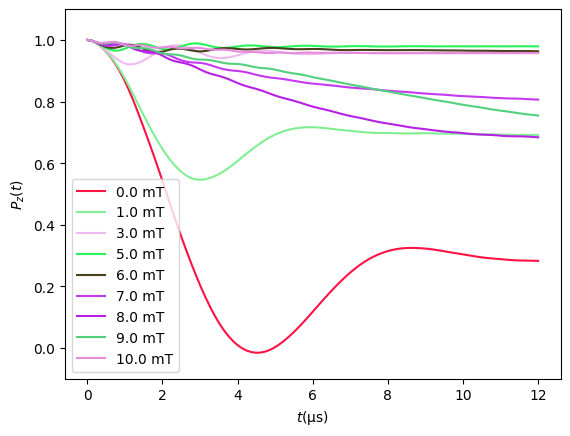

In [18]:
from undi import MuonNuclearInteraction
import matplotlib.pyplot as plt

#| ## Define lattice structure
#|
#| The octahedral muon site in Cu is defined below.

angtom=1.0e-10 # m
a=3.6212625504 # Cu lattice constant, in Angstrom

Cu_Quadrupole_moment =  (-0.211) * (10**-28) # m^2
atoms = [

    {'Position': np.array([0.5, 0.5, 0.5]) * a * angtom,
     'Label': 'mu'},

    {'Position': np.array([0.0    ,    0.5   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment # 'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.0   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([1.0    ,   0.5   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    1.0   ,     0.5])*angtom*a,
     'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.5   ,     0.0])*angtom*a,
    'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
    'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    },

    {'Position': np.array([0.5    ,    0.5   ,     1.0])*angtom*a,
     'Label': '63Cu',
     'Spin': 3/2,
     'Gamma': 7.0974e7,
     'ElectricQuadrupoleMoment': Cu_Quadrupole_moment, # 'OmegaQmu': 3.2e6 # s^-1
    }
]



#| ## Set Electric Field Gradient
#|
#| There are two ways of treating quadrupole coupling with UNDI.
#| One can either explicitly set the EFG tensor, or specify 'OmegaQmu'
#| that assumes that the EFG is only generated by the muon, which is
#| the case for nuclei occupying positions with cubic symmetry.
#| We opt for the first option here since the latter is deprecated.


elementary_charge=1.6021766E-19 # Coulomb = ampere ⋅ second

def Vzz_for_unit_charge_at_distance(r):
    epsilon0 = 8.8541878E-12            # ampere^2 ⋅ kilogram^−1 ⋅ meter^−3 ⋅ second^4
    elementary_charge=1.6021766E-19     # Coulomb = ampere ⋅ second
    Vzz = (2./(4 * np.pi * epsilon0)) * (elementary_charge / (r**3))
    return Vzz

def Vzz_from_Celio_PRL():
    # The value used for the EFG is taken from PRL 39 836, that reports
    #    q = 0.27(15) angstrom^−3
    # (4 pi epsilon_0)^−1 (0.27 angstrom^−3) elementary_charge = 3.8879043E20 meter^−2 ⋅ volts
    #
    # the factor 1.02702 appearing below is only used to obtain exactly the value
    # used by Celio in his pioneering work, namely omega_q = 3.2e6 s^-1.
    #
    Vzz = 1.02702 * 3.8879043E20
    return Vzz

def gen_radial_EFG(p_mu, p_N, Vzz):
    x=p_N-p_mu
    n = np.linalg.norm(x)
    x /= n; r = 1. # keeping formula below for clarity
    return -Vzz * ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 ) * 0.5
    # Final note, the last 0.5 is required since
    #  that the formula
    #     ( (3.*np.outer(x,x)-np.eye(3)*(r**2))/r**5 )
    #
    #  would give for p_mu=np.array([0,0,0.]) and p_N=np.array([0,0,1.])
    #
    #    array([[ 1., -0., -0.],
    #           [-0.,  1., -0.],
    #           [-0., -0., -2.]])
    #
    # thus the largest eigenvalue is 2 (absolute value is intended),
    # that multiplied by Vzz would give 2Vzz.


for idx, atom in enumerate(atoms):
    if atom['Label'] == '63Cu':
        atoms[idx]['EFGTensor'] = gen_radial_EFG(atoms[0]['Position'], atom['Position'], Vzz_from_Celio_PRL())

#| ## Polarization function
#|
#| The muon polarization is obtained with the method introduced by Celio.





# import matplotlib as mpl; mpl.style.use(['bmh', 'paper', 'paper_twocol'])
LongitudinalFields = (0.0, 0.001, 0.003, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01)

steps = 100
tlist = np.linspace(0, 12e-6, steps)
signals = np.zeros([len(LongitudinalFields),steps], dtype=np.float64)

for idx, Bmod in enumerate(LongitudinalFields):

    # Put field along muon polarization, that is always z
    B = Bmod * np.array([0,0.,1.])
    NS = MuonNuclearInteraction(atoms, external_field=B, log_level='error')

    # rotate the sample such that the muon spin is aligned with
    # the 111 direction (and, just for convenience, the muon position is
    # set to (0,0,0) )
    NS.translate_rotate_sample_vec(np.array([1.,1.,1.]))

    print("Computing signal 4 times with LF {} T...".format(Bmod), end='', flush=True)
    signal_Cu = NS.celio_on_steroids(tlist,  k=1, progress=False)
    for i in range(3):
        print('{}...'.format(i+1), end='', flush=True)
        signal_Cu += NS.celio_on_steroids(tlist, k=1, progress=False)
    print('done!')
    signal_Cu /= float(i+1+1)
    del NS

    signals[idx]=signal_Cu


#| ...and the results is:


fig, axes = plt.subplots(1,1)
for i, Bmod in enumerate(LongitudinalFields):
    color = list(np.random.choice(range(256), size=3)/256)
    axes.plot(1e6*tlist, signals[i], label='{} mT'.format(Bmod*1e3), linestyle='-', color=color)
axes.set_ylim((-0.1,1.1))
axes.set_ylabel(r'$P_z(t)$')
axes.set_xlabel(r'$t \mathrm{(\mu s)}$')
plt.legend()
plt.show()



3.992955474186e+20